# MS Topo Layer API Query

In [1]:
import os
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon
from shapely import box
from osdatahub import NGD
from osdatahub import Extent
from dotenv import load_dotenv
from shapely.geometry import Polygon

#### Setting up the API
Location data is fetched from OS Data Hub APIs. This analysis uses Premium data from the OS Features API, so you will need a Premium account.

In [2]:
# Set API key, details from https://github.com/OrdnanceSurvey/osdatahub
load_dotenv()
key_os = os.environ['KEY']

In [4]:
ngd_collections = NGD.get_collections()
for collection in ngd_collections['collections']:
    print(f' - {collection["title"]} ({collection["id"]})')

 - Building Line v1 (bld-fts-buildingline-1)
 - Building Part v1 (bld-fts-buildingpart-1)
 - Named Area v1 (gnm-fts-namedarea-1)
 - Named Point v1 (gnm-fts-namedpoint-1)
 - Land v1 (lnd-fts-land-1)
 - Landform v1 (lnd-fts-landform-1)
 - Landform Line v1 (lnd-fts-landformline-1)
 - Landform Point v1 (lnd-fts-landformpoint-1)
 - Land Point v1 (lnd-fts-landpoint-1)
 - Site v1 (lus-fts-site-1)
 - Site Access Location v1 (lus-fts-siteaccesslocation-1)
 - Site Routing Point v1 (lus-fts-siteroutingpoint-1)
 - Compound Structure v1 (str-fts-compoundstructure-1)
 - Structure v1 (str-fts-structure-1)
 - Structure Line v1 (str-fts-structureline-1)
 - Structure Point v1 (str-fts-structurepoint-1)
 - Cartographic Rail Detail v1 (trn-fts-cartographicraildetail-1)
 - Rail v1 (trn-fts-rail-1)
 - Road Line v1 (trn-fts-roadline-1)
 - Road Track Or Path v1 (trn-fts-roadtrackorpath-1)
 - Connecting Link v1 (trn-ntwk-connectinglink-1)
 - Connecting Node v1 (trn-ntwk-connectingnode-1)
 - Ferry Link v1 (trn-

#### Fetching Data

In [5]:
# set the geographic variables
crs = "EPSG:27700"

# Define a rectangle by passing an ordered list of coordinate tuples 
# [404000, 348000, 428000, 384000] site-area.ipynb
SW = (417000, 368000)
SE = (418000, 368000)
NE = (418000, 369000)
NW = (417000, 369000)
square = Polygon([SW, SE, NE, NW])
# Create the extent
extent = Extent(square, crs=crs)

In [6]:
# API variables
collection = "str-fts-structureline-1"
str_ngd = NGD(key_os, collection)

# call features from API 
str_features = str_ngd.query(extent=extent, crs=crs, max_results=10000000)

#### Process the data 

In [7]:
# create gpd df
str_gdf = gpd.GeoDataFrame.from_features(str_features, crs=crs)
#subset based on 'Built Obstruction' can't figure out a way to filter the API yet
groups = str_gdf['description'].unique()
print(groups)

['Built Obstruction' 'Gate or Barrier']


In [8]:
# filter
str_gdf = str_gdf[str_gdf['description'] == 'Built Obstruction']
str_gdf.head(2)

,geometry,osid,toid,theme,istidal,changetype,ishistoric,isobscured,description,versiondate,...,operationalstatus,description_source,geometry_updatedate,capturespecification,geometry_evidencedate,description_updatedate,versionavailabletodate,firstdigitalcapturedate,description_evidencedate,versionavailablefromdate
0,"LINESTRING (417584.884 368683.203, 417583.801 ...",00464ee2-cb64-4883-a9fc-cd1ff447af7d,osgb5000005273447662,Structures,False,New,False,False,Built Obstruction,2022-08-26,...,Unknown,Ordnance Survey,2020-12-03,Rural,2020-05-29,2020-12-03,None,2020-12-04,2020-05-29,2022-08-27T00:00:00Z
1,"LINESTRING (417439.990 368765.300, 417434.910 ...",006bfd46-2896-4fc1-81be-492ebbe39b7c,osgb1000000108317696,Structures,False,New,False,False,Built Obstruction,2022-08-26,...,Unknown,Ordnance Survey,2005-10-13,Rural,2005-10-13,2005-10-13,None,1992-07-27,2005-10-13,2022-08-27T00:00:00Z


(Text(0.5, 69.0, 'Eastings'), Text(111.07282932210325, 0.5, 'Northings'))

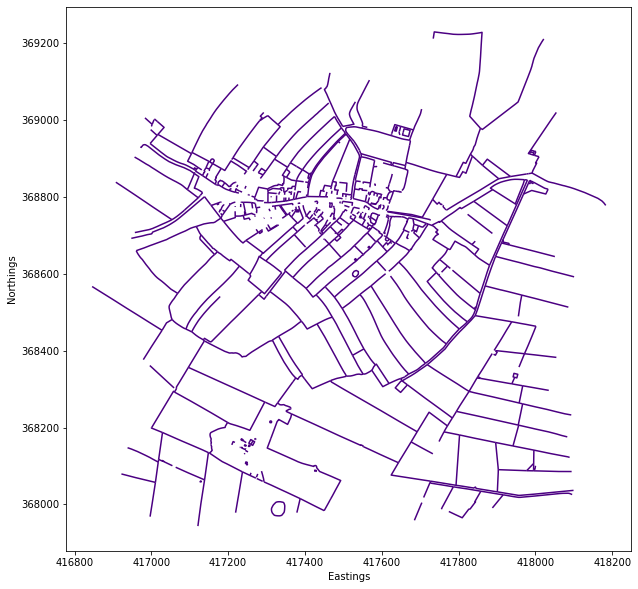

In [67]:
ax = str_gdf.plot(color="indigo", figsize=(12, 10))
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")

In [57]:
# save as a new file 
out_file_path = r"../content/ngd_boundaries/structureline_wp.shp"
str_gdf.to_file(out_file_path)

C:\Users\alexad\AppData\Local\Temp\ipykernel_22016\2824885496.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  str_gdf.to_file(out_file_path)


##### Create layer for overriding Urban Area 

In [38]:
# based on cnn-land-cover/notebooks/Create manual layer to override model predictions.ipynb (@vdplasthijs)
# apart from roads as many walls feature at the side of roads in the WP

collections = {'buildings' : 'bld-fts-buildingpart-1',
               'sites' : 'lus-fts-site-1', 
               'railways' : 'trn-fts-rail-1', 
               'water' : 'wtr-fts-waterpoint-1', 
               'land' : 'lnd-fts-land-1'}

for key, value in collections.items():
    ngd = NGD(key_os, value)
    ngd_ = "ngd_" + key
    globals()[ngd_] = ngd.query(extent=extent, crs=crs, max_results=10000000)
    # convert to gpd  
    if globals()[ngd_]['numberReturned'] > 0:
        print(globals()[ngd_]['numberReturned'])
        globals()[ngd_] = gpd.GeoDataFrame.from_features(globals()[ngd_], crs=crs)
        # Assert all geometry types are polygons
        set_unique_geom_types = set([type(x) for x in globals()[ngd_]['geometry']])
        for geom_type in set_unique_geom_types:
            assert geom_type in [shp.geometry.polygon.Polygon, shp.geometry.multipolygon.MultiPolygon], f'Unexpected geometry type {geom_type} for {key}'
    else:
        print("Dictionary is empty!")
    

177
54
Dictionary is empty!
Dictionary is empty!
410


In [37]:
# double check which were converted
all_var = (ngd_buildings, ngd_land, ngd_railways, ngd_sites, ngd_water)
for x in all_var:
    if isinstance(x, gpd.GeoDataFrame):
        print("yes")
    else:
        print("no")   
 

yes
yes
no
yes
no


In [36]:
# Select land 
groups_land = ngd_land['description'].unique()
groups_land

array(['Made Surface', 'Arable Or Grazing Land', 'Residential Garden',
       'Bare Earth Or Grass', 'Heath Or Rough Grassland',
       'Non-Coniferous Trees', 'Mixed Trees',
       'Non-Coniferous Trees And Scrub'], dtype=object)

In [41]:
# filter
ngd_land = (ngd_land.loc[(ngd_land['description']== 'Residential Garden') & (ngd_land['description']== 'Residential Garden')])
ngd_land.head(2)

,geometry,osid,toid,theme,istidal,landform,changetype,isobscured,description,versiondate,...,oslanduse_updatedate,geometry_evidencedate,description_updatedate,oslandcover_updatedate,oslanduse_evidencedate,versionavailabletodate,firstdigitalcapturedate,description_evidencedate,oslandcover_evidencedate,versionavailablefromdate
2,"POLYGON ((417465.470 368748.430, 417473.030 36...",00eeb884-edad-4321-a78a-f8f469e990c9,osgb1000000108318860,Land,False,None,New,False,Residential Garden,2022-09-16,...,2015-04-21,2005-10-13,2015-04-21,2015-04-21,2014-07-24,None,2000-09-30,2014-07-24,2014-07-24,2022-09-17T00:00:00Z
11,"POLYGON ((417365.080 368814.980, 417359.090 36...",07be5ec4-13d1-4a6e-bc09-848aedbc5831,osgb1000000108318811,Land,False,None,Moved From A Different Feature Type,False,Residential Garden,2022-09-16,...,2022-01-04,2005-10-13,2022-01-04,2022-01-04,2022-01-04,None,2000-09-30,2022-01-04,2022-01-04,2022-09-17T00:00:00Z


In [20]:
# select site
groups_site = ngd_sites['description'].unique()
groups_site

array(['Private Residential Site', 'Industry And Business Site', 'Church',
       'Quarry', 'Unclassified Site', 'Community Meeting Place',
       'Public House', 'Recreation Ground', 'Electricity Sub Station',
       'Play Area', 'Waste Water Treatment Works'], dtype=object)

(Text(0.5, 69.0, 'Eastings'), Text(111.07282932210325, 0.5, 'Northings'))

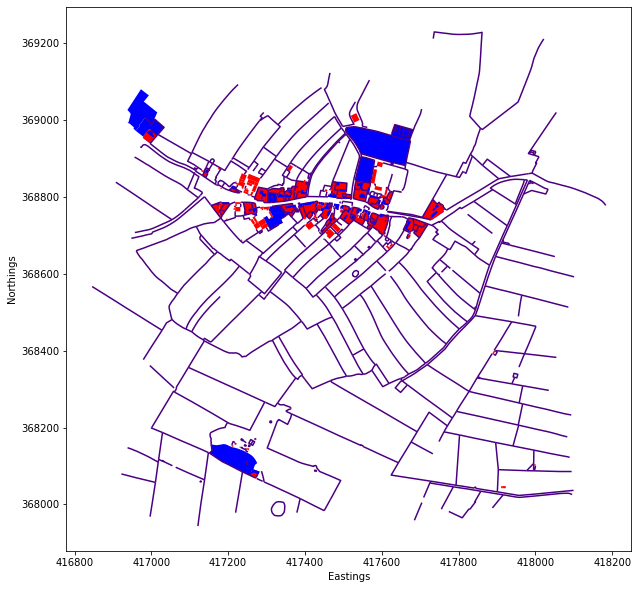

In [43]:
ax = str_gdf.plot(color="indigo", figsize=(12, 10))
ngd_buildings.plot(ax=ax, color="red")
ngd_sites.plot(ax=ax, color="red")
ngd_land.plot(ax=ax, color='red')
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")

In [ ]:
# probably just use the geopakage data? :)